# Module 8: Working with a small signal

If you are collecting atomic and magnetic PDF simultaneously, the mPDF signal is often much smaller than the atomic PDF, sometimes even on the level of the noise in the atomic PDF fit. One way to deal with this is to collect data at a higher temperature where the mPDF signal is absent (e.g. well above the magnetic ordering temperature), do a regular atomic PDF fit to the high-temperature data, and subtract that fit residual from the fit residual you get when performing the atomic PDF fit to the low-temperature data, where the mPDF signal is small but nonzero. This allows you to subtract out temperature-independent (and therefore presumably nonmagnetic) noise or errors in your data, providing a cleaner mPDF signal to work with. We will work through an example of this approach in this module. 

The material we will use for our example is the multiferroic system Sr0.55Ba0.45MnO3, which undergoes an antiferromagnetic transition around 200 K. Mn is the only magnetic atom. We collected neutron PDF data on the NOMAD beamline at several temperature between 90 K and 500 K. We will do an mPDF fit to the 90 K data, using the data collected at 360 K as our high-temperature reference measurement for the temperature subtraction. The atomic PDF fits have already been done in PDFgui.

The following files will be relevant for this module:
 - SBMOfit_PDFgui_90K.fgr: best-fit atomic PDF at 90 K
 - SBMOfit_PDFgui_360K.fgr: best-fit atomic PDF at 360 K
 - struc_SBMO.stru: refined structure produced by PDFgui

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

from diffpy.mpdf import *
from diffpy.structure import loadStructure

%matplotlib notebook 
# run this cell twice

### Inspect the structure and determine the magnetic propagation/basis vectors

Load in the refined structure file using loadStructure(). Print out the structure to determine which index corresponds to the magnetic atom. Convince yourself that the Mn atoms sit on the vertices of a simple pseudocubic lattice (pseudocubic because there is a very slight tetragonal distortion).

In [3]:
struc = loadStructure('files/struc_SBMO.stru')
print(struc)

lattice=Lattice(a=3.86078, b=3.86078, c=3.83773, alpha=90, beta=90, gamma=90)
Sr   0.500000 0.500000 0.500000 0.5500
Ba   0.500000 0.500000 0.500000 0.4500
Mn   0.000000 0.000000 0.002737 1.0000
O    0.500000 0.000000 -0.010268 1.0000
O    0.000000 0.500000 -0.010268 1.0000
O    0.000000 0.000000 0.495395 1.0000


The magnetic order is known to be G-type, which means each Mn spin is antiferromagnetically coupled with its 6 nearest neighbors. Further more, the spins are known to be oriented up and down along the c axis. Use this information to determine the propagation vector and basis vector to describe this magnetic structure.

 - Propagation vector: (1/2, 1/2, 1/2)
 - Basis vector: (0, 0, 1)

### Calculate and plot the expected mPDF pattern so we know what to look for

<IPython.core.display.Javascript object>


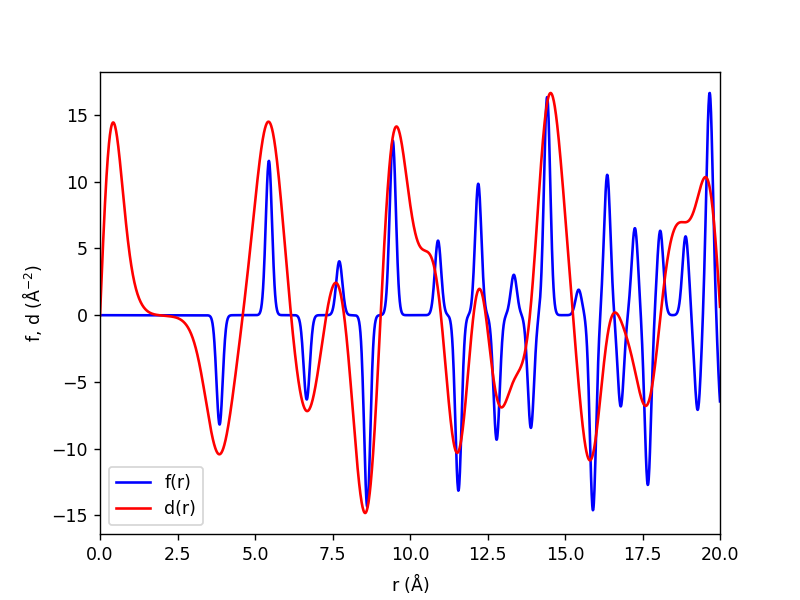

In [4]:
svec = np.array([0, 0, 1]) # spin vector
mspec = MagSpecies(struc=struc,strucIdxs=[2],
                   basisvecs=svec,kvecs=np.array([0.5,0.5,0.5]),rmaxAtoms=25,
                   ffparamkey='Mn4',origin=struc[2].xyz_cartn)
mstruc = MagStructure()
mstruc.loadSpecies(mspec)
mstruc.makeAll() ### populates the spin and atom arrays
mc = MPDFcalculator(magstruc=mstruc,qdamp=0.025)
rmag, gmagNrm, gmag = mc.calc(both=True)
mc.plot(both=True)

### Inspect the fit residuals and look for evidence for a magnetic PDF signal

<IPython.core.display.Javascript object>


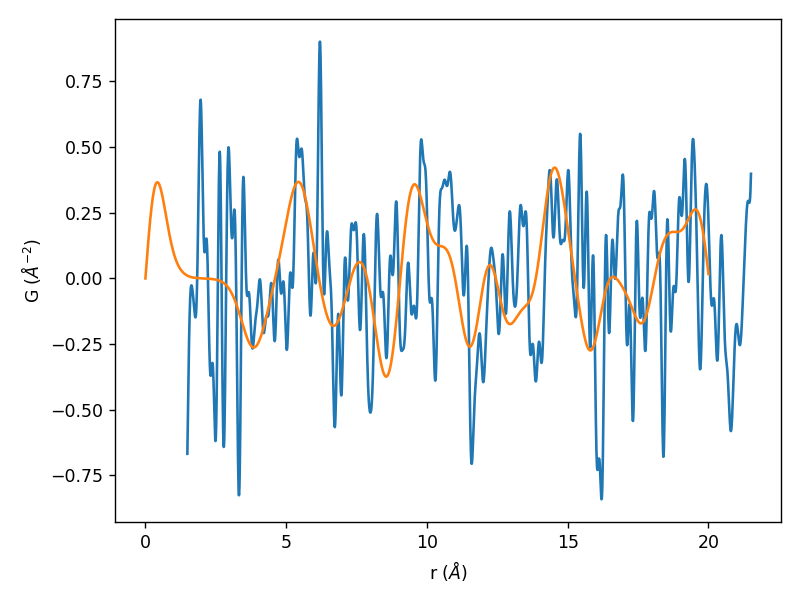

In [5]:
### Read in the fits done at 90 K and 360 K
r, gobs, gcalc, gdiff = read_fgr('files/SBMOfit_PDFgui_90K.fgr')
r360, gobs360, gcalc360, gdiff360 = read_fgr('files/SBMOfit_PDFgui_360K.fgr')

### Plot the 90 K fit residual with the calculated mPDF (scaled to match the data)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('r ($\AA$)')
ax.set_ylabel('G ($\AA^{-2}$)')
ax.plot(r, gdiff)
ax.plot(rmag, gmag*0.01)
plt.tight_layout()
plt.show()

It looks like there could be some rough agreement between the fit residual and the calculated mPDF. (Note that the high-frequency wiggles in the fit residual cannot possibly be magnetic in origin, since the mPDF is guaranteed to be much broader than that.)

Let's try to clean up the signal by subtracting the high-temperature data.

<IPython.core.display.Javascript object>


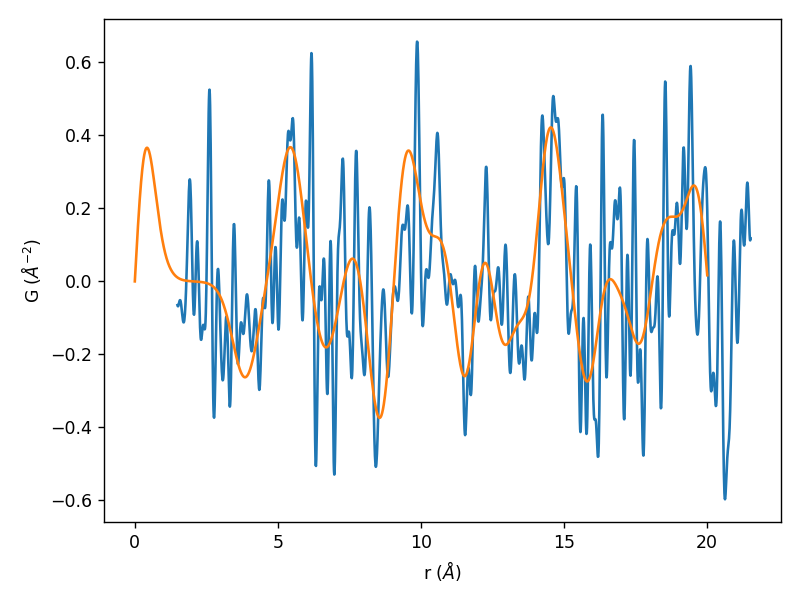

In [6]:
gdiffSub = gdiff - gdiff360

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('r ($\AA$)')
ax.set_ylabel('G ($\AA^{-2}$)')
ax.plot(r, gdiffSub)
ax.plot(rmag, gmag*0.01)
plt.tight_layout()
plt.show()

This is starting to look promising! We can do one more trick to improve the subtraction: run the optimizedSubtraction() routine, which attempts to account for thermal expansion and thermal broadening by applying stretching and broadening operations to the low-temperature data. Execute the cell below to learn more about how it works.

In [16]:
optimizedSubtraction?

[0.99499935 0.08028457]


<IPython.core.display.Javascript object>


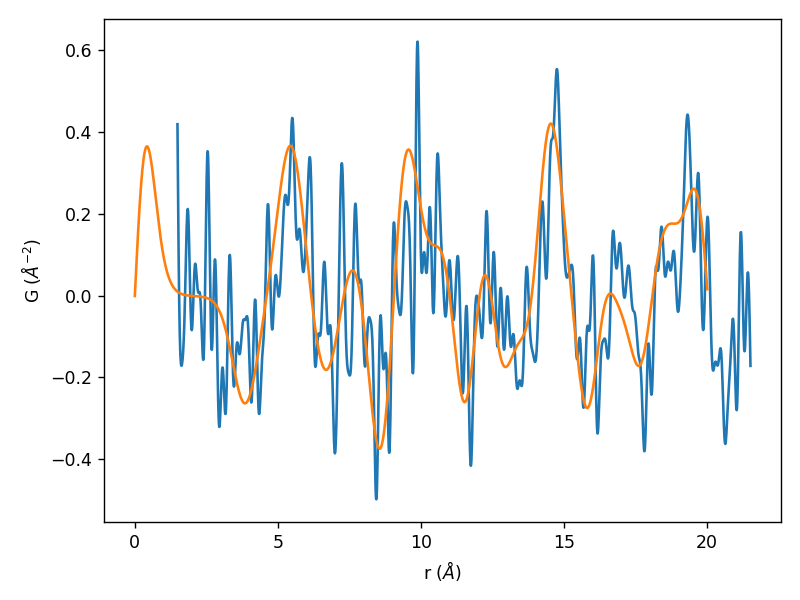

In [7]:
r_opt, gdiff_opt = optimizedSubtraction(r360, gdiff360, r, gdiff)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('r ($\AA$)')
ax.set_ylabel('G ($\AA^{-2}$)')
ax.plot(r_opt, gdiff_opt)
ax.plot(rmag, gmag*0.01)
plt.tight_layout()
plt.show()

We can also apply an aesthetic correction. Since we know the high-frequency noise cannot be magnetic in origin, we can filter it out using the smoothData() function. Learn more about it below:

In [19]:
smoothData?

We will just use the standard step-function cutoff. Let's try 6 A^-1 and see how that looks.

<IPython.core.display.Javascript object>


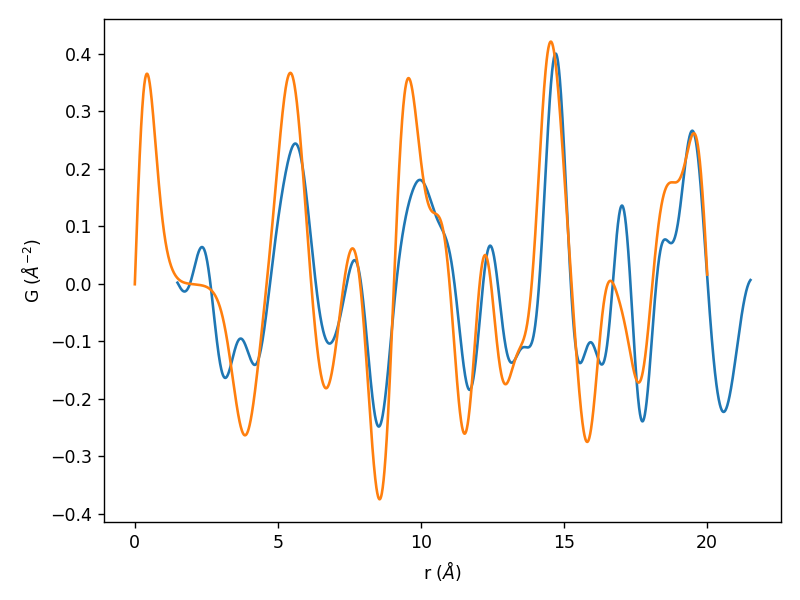

In [8]:
gsmooth = smoothData(r_opt, gdiff_opt, 6)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('r ($\AA$)')
ax.set_ylabel('G ($\AA^{-2}$)')
ax.plot(r_opt, gsmooth)
ax.plot(rmag, gmag*0.01)
plt.tight_layout()
plt.show()

Not bad! Now we can do an actual fit to improve the agreement. Note that we should fit to the original data, not the smoothed data, but we can always do the visual comparison with the smoothed data to see how it looks.

For fitting parameters, let's choose the two scale factors (paraScale and ordScale) and the two spherical angles to allow us to refine the spin direction. To keep things simple, we'll just use least_squares directly without implementing the full diffpy.srfit framework.

In [9]:
### Update rmin and rmax to agree with the data
mc.rmin = r_opt.min()
mc.rmax = r_opt.max()

### Define masks for the up and down spins

upSpins = np.all(mstruc.spins == mstruc.spins[0], axis=1)
downSpins = ~upSpins

# Define the mPDF function that will be evaluated in the fit
def mpdf(p):
    ordscale, parascale, th, phi = p
    mc.ordScale = ordscale
    mc.paraScale = parascale
    sx = np.sin(th)*np.cos(phi)
    sy = np.sin(th)*np.sin(phi)
    sz = np.cos(th)
    newSvec = np.array([sx, sy, sz])
    mstruc.spins[upSpins] = 1.0*newSvec
    mstruc.spins[downSpins] = -1.0*newSvec
    return mc.calc(both=True)[2]


def residual(p, data):
    return data - mpdf(p)

# set starting parameter values (same order as defined in the mpdf(p) function)
p0 = [0.01, 0.01, np.pi/2, 0] 

# set reasonable lower and upper bounds for the parameters
lb = [0, 0, 0, -np.pi]
ub = [10, 10, np.pi, np.pi]
opt = least_squares(residual, p0, bounds=[lb,ub], args=(gdiff_opt,)) # passing gdiff_opt as the "data" argument in residual()

# print the refined parameter values
print(opt.x)

# calculate the best-fit mPDF to plot later
magcalc = mpdf(opt.x)

# print out the refined spin direction
print(mstruc.spins[0])

[6.71107155e-03 9.23142649e-03 1.59544460e-04 3.12834139e+00]
[-1.59530452e-04  2.11410394e-06  9.99999987e-01]


Plot the results! We'll plot both the atomic and magnetic PDF fits.

<IPython.core.display.Javascript object>


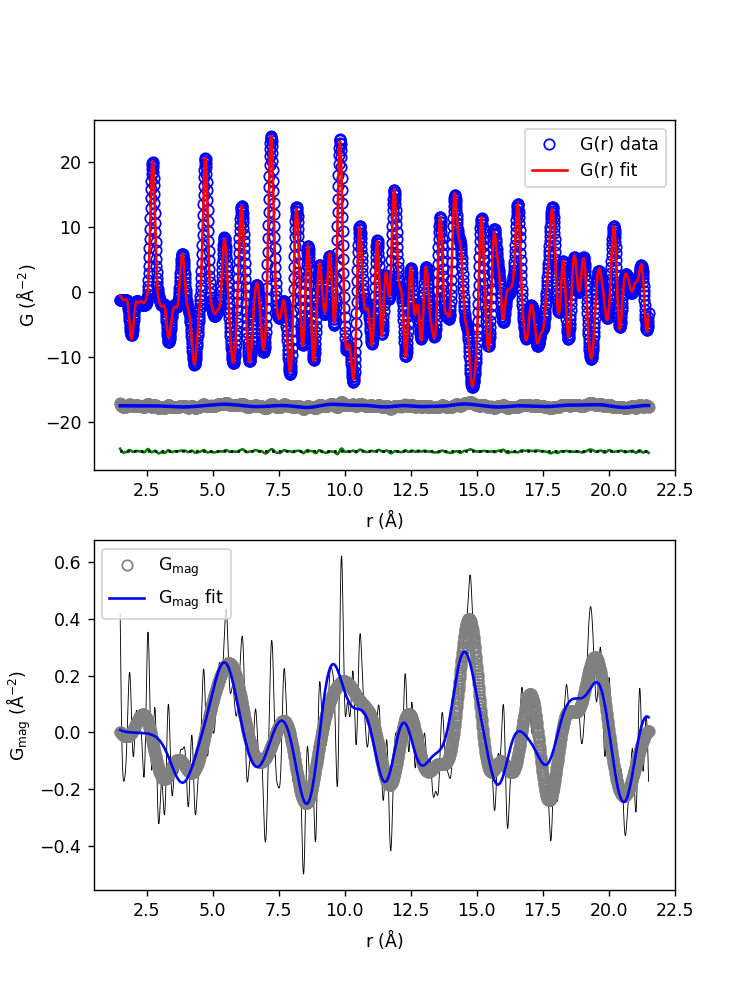

In [11]:
baseline = 1.2 * gobs.min()
overall_residual = gdiff_opt - magcalc

fig = plt.figure(figsize=(6,8))
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax.plot(r, gobs, 'bo', label="G(r) data",markerfacecolor='none', markeredgecolor='b')
ax.plot(r, gcalc+magcalc, 'r-', lw=1.5, label="G(r) fit")
ax.plot(r, gdiff_opt + baseline,marker='o',mec='Gray',mfc='None',linestyle='None')
ax.plot(r, magcalc + baseline, marker='None',color='Blue',lw=2)
ax.plot(r, overall_residual+1.4*baseline, 'g-')
ax.plot(r, np.zeros_like(r) + 1.4*baseline, 'k:')


ax.set_xlabel(r"r ($\mathdefault{\AA}$)")
ax.set_ylabel(r"G ($\mathdefault{\AA^{-2}}$)")

ax2.plot(r, gdiff_opt, linestyle='-', lw=0.5, color='k') # unsmoothed version
ax2.plot(r, gsmooth, marker='o',mec='Gray',mfc='None',linestyle='None', label='G$_{\mathdefault{mag}}$') #smoothed version
ax2.plot(r, magcalc, 'b-', lw=1.5, label="G$_{\mathdefault{mag}}$ fit")
ax.legend()
ax2.legend()
ax2.set_xlabel(r"r ($\mathdefault{\AA}$)")
ax2.set_ylabel(r"G$_{\mathdefault{mag}}$ ($\mathdefault{\AA^{-2}}$)")

plt.show()

In [12]:
plt.close('all')

Let's check the ordered moment that corresponds to our fit. This is a good sanity check; if we get an unreasonably large or small value, it could mean that there is something wrong with the fit.

In [13]:
nucScale = 0.613

calculate_ordered_moment(mc, nucScale)

1.85370386503453

This seems like a reasonable value for Mn4+. Another successful mPDF fit!